**ML PROBLEM 5.1**

In [2]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LassoCV, Lasso
from sklearn import linear_model
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import *
import warnings
import os
from sklearn import preprocessing
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score
warnings.filterwarnings("ignore")
import keras
import torch
from keras import *

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
X_train = np.load(os.path.abspath('/content/drive/MyDrive/Machinelearning5.1/Xtrain_Classification1.npy'))
y_train = np.load(os.path.abspath('/content/drive/MyDrive/Machinelearning5.1/ytrain_Classification1.npy'))
X_test  = np.load(os.path.abspath('/content/drive/MyDrive/Machinelearning5.1/Xtest_Classification1.npy'))

**Neural Network**


In [4]:
def balance_augmentation(x, y):
    """
    Function that takes x and y data and outputs augmented x and y data, such that the number of samples of each of the two classes is the same
    """
    #separating x into matrixes with only one class of image - to enable to only augment the underrepresented class of images
    x_melanoma1 = np.empty([0,x.shape[1]])
    x_nervu0 = np.empty([0,x.shape[1]])
    for index,item in np.ndenumerate(y):
        if item:
            x_melanoma1 = np.vstack([x_melanoma1, x[index,:]])
        else:
            x_nervu0 = np.vstack([x_nervu0, x[index,:]])
    #Checking the imbalance in the data
    nr_y_melanoma=len([y for y in y_train if y])
    nr_y_nevu=len([y for y in y_train if not y])
    difference = nr_y_nevu - nr_y_melanoma
    #choosing to augment only the underrepresented class of data
    if difference >0:
        X_generator_train=x_melanoma1
        y_class_to_augment=1
    else:
        X_generator_train=x_nervu0
        y_class_to_augment=0
    y_generator_train=np.empty([X_generator_train.shape[0], 1])
    y_generator_train[:]=y_class_to_augment
    #creating and fitting image data generator
    data_generator = keras.preprocessing.image.ImageDataGenerator(
        rotation_range=360,
        width_shift_range=5,
        height_shift_range=5,
        brightness_range=[0.7,1.3],
        zoom_range=0.2,
        fill_mode='nearest',
        horizontal_flip=True,
        vertical_flip=True)
    X_generator_train_reshape = np.reshape(X_generator_train,(X_generator_train.shape[0],28,28,3))
    data_generator.fit(X_generator_train_reshape)
    #creating arrays of new data/augmented data - only of underrepresented class
    x_augmented = np.empty([0,x.shape[1]])
    y_augmented = np.empty([0, 1])
    #generating data
    for batch_x, batch_y in data_generator.flow(X_generator_train_reshape, y_generator_train, batch_size=10, seed=1000):
        x_augmented = np.vstack([x_augmented,np.reshape(batch_x,(batch_x.shape[0],2352))])
        y_augmented = np.vstack([y_augmented, np.reshape(batch_y,(batch_y.shape[0],1))])
        if x_augmented.shape[0] >= difference - 500:
            break
    balanced_x=np.vstack([x, x_augmented])
    balanced_y=np.vstack([np.reshape(y, (y.shape[0],1)), y_augmented])
    return balanced_x, balanced_y

In [5]:
def data_augmentation(x, y, augmentation_factor):
    #augmentation_factor is total nr_samples after augmentation / original nr of samples (always >1)
    data_generator = keras.preprocessing.image.ImageDataGenerator(
        rotation_range=360,
        width_shift_range=5,
        height_shift_range=5,
        brightness_range=[0.7,1.3],
        zoom_range=0.2,
        fill_mode='nearest',
        horizontal_flip=True,
        vertical_flip=True)
    X_train_reshape = np.reshape(x,(x.shape[0],28,28,3))
    data_generator.fit(X_train_reshape)
    #creating arrays of new data/augmented data
    x_augmented = np.empty([0,x.shape[1]])
    y_augmented = np.empty([0, 1])
    #generating data
    for batch_x, batch_y in data_generator.flow(X_train_reshape, y, batch_size=32, seed=500):
        x_augmented = np.vstack([x_augmented,np.reshape(batch_x,(batch_x.shape[0],2352))])
        y_augmented = np.vstack([y_augmented, np.reshape(batch_y,(batch_y.shape[0],1))])
        if x_augmented.shape[0] > (x.shape[0])*(augmentation_factor-1): #stops when generated enougth data to satisfy the augmentation factor
            break
    x_train_aug=np.vstack([x, x_augmented])
    y_train_aug=np.vstack([np.reshape(y, (y.shape[0],1)), y_augmented])
    return x_train_aug, y_train_aug


In [6]:
from sklearn.model_selection import train_test_split

def shuffle_data(x, y):
    permutation = np.random.permutation(len(x))
    x_shuffled = x[permutation]
    y_shuffled = y[permutation]
    return x_shuffled, y_shuffled

def x_y_preprocessing(x,y, validation_size, augmentetion_ratio,balance_aug_bool, shuffle_bool):
    X_train_normalizado= x/255
    if shuffle_bool:
      x_shuffled, y_shuffled = shuffle_data(X_train_normalizado,y)
    else:
      x_shuffled, y_shuffled=X_train_normalizado,y

    X_train, X_val, y_train, y_val = train_test_split(x_shuffled, y_shuffled, test_size=validation_size)

    if balance_aug_bool:
      X_train_balanced , y_train_balanced = balance_augmentation(X_train, y_train)
      x_reshuffle, y_reshuffle = shuffle_data(X_train_balanced , y_train_balanced)
    elif shuffle_bool:
      x_reshuffle, y_reshuffle = shuffle_data(X_train, y_train)
    else:
      x_reshuffle, y_reshuffle = X_train, y_train

    augmented_x_train, augmented_y_train= data_augmentation(x_reshuffle, y_reshuffle, augmentetion_ratio) #dados nao balanceados mas aumentados - 2x mais dados

    X_train_sample = np.reshape(augmented_x_train,(augmented_x_train.shape[0],28,28,3))
    x_val_sample = np.reshape(X_val,(X_val.shape[0],28,28,3))
    y_train_2labels = keras.utils.to_categorical(augmented_y_train, num_classes=2)
    y_val_2labels = keras.utils.to_categorical(y_val, num_classes=2)

    return  X_train_sample, y_train_2labels, x_val_sample , y_val_2labels







In [7]:
#metrics

from keras import backend as k
def onehot(y_onehot):
    y = y_onehot[:,1]
    return y

def specificity_custom(y_pred_onehot, y_true_onehot):
    y_pred, y_true = onehot(y_pred_onehot), onehot(y_true_onehot)
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    fp = k.sum(neg_y_true * y_pred)
    tn = k.sum(neg_y_true * neg_y_pred)
    return tn / (tn + fp)

def sensitivity_custom(y_pred_onehot, y_true_onehot): #sensitivity=recall
    y_pred, y_true = onehot(y_pred_onehot), onehot(y_true_onehot)
    neg_y_pred = 1 - y_pred
    fn = k.sum(neg_y_pred*y_true)
    tp = k.sum(y_true*y_pred)
    return tp / (tp + fn)

def balanced_accuracy_custom(y_pred, y_true):
    specificity_val = specificity_custom(y_pred, y_true)
    sensitivity_val = sensitivity_custom(y_pred, y_true)
    return (specificity_val + sensitivity_val)/2


def precision_custom(y_pred_onehot, y_true_onehot):
    y_pred, y_true = onehot(y_pred_onehot), onehot(y_true_onehot)
    neg_y_true = 1 - y_true
    fp = k.sum(neg_y_true * y_pred)
    tp = k.sum(y_true*y_pred)
    return tp / (tp + fp)

def balanced_accuracy_enunciado(y_pred, y_true):
    precision_val = precision_custom(y_pred, y_true)
    recall_val = sensitivity_custom(y_pred, y_true)#sensitivity=recall
    return (precision_val + recall_val)/2

class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_balanced_accuracy_custom') >= 0.8:
            self.model.stop_training = True


In [8]:
from sklearn.utils import class_weight
def weighted_balance(y_Data):
    class_weights = class_weight.compute_class_weight(class_weight ='balanced', classes = np.unique(y_Data) ,y=np.reshape(y_Data, (y_Data.shape[0],)))
    return dict(enumerate(class_weights))


In [9]:

def save_model (model_fitted, model_history, optimizer_string, loss_string ,epoch_nr,batch,best_balancedAccuracy ):

    #define names for the files
    file_name_model=f"bestbacc_{best_balancedAccuracy}  {optimizer_string}  {loss_string}  Epoch_{epoch_nr}  Batch_{batch}  Model.keras"
    #model_path=Path(r'C:\Users\alexa\OneDrive - Universidade de Lisboa\4º Ano\1º Semestre - MEEC\Aprendizagem Automática\Labs2\ML_Aaut',file_name_model)
    file_name_history=f"bestbacc_{best_balancedAccuracy}  {optimizer_string}  {loss_string}  Epoch_{epoch_nr}  Batch_{batch}  History.npy"
    #history_path=Path(r'C:\Users\alexa\OneDrive - Universidade de Lisboa\4º Ano\1º Semestre - MEEC\Aprendizagem Automática\Labs2\ML_Aaut',file_name_history)

    #save the model in a .keras file
    model_fitted.save(file_name_model)
    #save history to numpy array
    np.save(file_name_history,model_history.history)


In [10]:
def model_def_0(optimizer_string, loss_string):
    model_img= keras.Sequential()
    model_img.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,3)))
    model_img.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model_img.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model_img.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model_img.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model_img.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))     #for simple image convolution 2-4 conv layers should be enougth. The number of filters in
    model_img.add(layers.MaxPooling2D(pool_size=(2, 2)))                        #each layer should start with 32-64 and increase with deeper layers, which enables the CNN to learn more abstract patterns
        #dense layers
    model_img.add(layers.Flatten())
    model_img.add(layers.Dense(256, activation='relu'))
    model_img.add(layers.Dense(64, activation='relu'))
    model_img.add(layers.Dense(2, activation='softmax'))


    model_img.compile(
            optimizer = optimizer_string,
            # Optimizer: use either ADAM or SGDM
            # Loss function to minimize
            loss = loss_string,
            # List of metrics to monitor
            metrics=[specificity_custom, sensitivity_custom ,balanced_accuracy_custom, balanced_accuracy_enunciado, keras.metrics.F1Score()])
    return model_img

In [11]:
def model_def_1(optimizer_string, loss_string):
    model_img= keras.Sequential()
    model_img.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,3),kernel_regularizer='l2'))
    model_img.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model_img.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu',kernel_regularizer='l2'))
    model_img.add(layers.BatchNormalization())
    model_img.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu',kernel_regularizer='l2'))
    model_img.add(layers.Dropout(0.1))
    model_img.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu',kernel_regularizer='l2'))
    model_img.add(layers.BatchNormalization())
    model_img.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu',kernel_regularizer='l2'))     #for simple image convolution 2-4 conv layers should be enougth. The number of filters in
    model_img.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model_img.add(layers.Dropout(0.1))                   #each layer should start with 32-64 and increase with deeper layers, which enables the CNN to learn more abstract patterns
        #dense layers
    model_img.add(layers.Flatten())
    model_img.add(layers.Dense(256, activation='relu',activity_regularizer='l2',bias_regularizer='l2'))
    model_img.add(layers.Dropout(0.3))
    model_img.add(layers.Dense(64, activation='relu',activity_regularizer='l2',bias_regularizer='l2'))
    model_img.add(layers.Dense(2, activation='softmax'))


    model_img.compile(
            optimizer = optimizer_string,
            # Optimizer: use either ADAM or SGDM
            # Loss function to minimize
            loss = loss_string,
            # List of metrics to monitor
            metrics=[specificity_custom, sensitivity_custom ,balanced_accuracy_custom, balanced_accuracy_enunciado, keras.metrics.F1Score()])
    return model_img

In [12]:
### Better Neural Network
def model_def_2(optimizer_string, loss_string):
    model_img= keras.Sequential()
    model_img.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,3),kernel_regularizer='l2'))
    model_img.add(layers.BatchNormalization())
    model_img.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,3),kernel_regularizer='l2'))
    model_img.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model_img.add(layers.Dropout(0.1))
    model_img.add(layers.Conv2D(64, kernel_size=(3, 3),padding="same", activation='relu',kernel_regularizer='l2' ))
    model_img.add(layers.BatchNormalization())
    model_img.add(layers.Conv2D(64, kernel_size=(3, 3),padding="same", activation='relu',kernel_regularizer='l2'))
    model_img.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model_img.add(layers.Dropout(0.15))
    model_img.add(layers.Conv2D(128,kernel_size=(3, 3), padding="same", activation='relu',kernel_regularizer='l2'))
    model_img.add(layers.Dropout(0.5))
    #we do not need to use a maxpooling layer after each convolution layer, but it helps reducing computacional load
    #for simple image convolution 2-4 conv layers should be enougth. The number of filters in
    #each layer should start with 32-64 and increase with deeper layers, which enables the CNN to learn more abstract patterns dense layers
    model_img.add(layers.Flatten())
    model_img.add(layers.Dropout(0.3))
    model_img.add(layers.Dense(64, activation='relu',activity_regularizer='l2',bias_regularizer='l2'))
    model_img.add(layers.Dropout(0.1))
    model_img.add(layers.Dense(2, activation='softmax'))

    model_img.compile(
            optimizer = optimizer_string,
            # Optimizer: use either ADAM or SGDM
            # Loss function to minimize
            loss = loss_string,
            # List of metrics to monitor
            metrics=[specificity_custom, sensitivity_custom ,balanced_accuracy_custom, balanced_accuracy_enunciado, keras.metrics.F1Score()])
    return model_img

In [13]:
def plot_neuralmodel(model):
    dtf = pd.DataFrame(model.history)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))
    fig.suptitle('Model Evaluation')
    best_bacc =round(max(dtf.iloc[:,9]),4)
    ax1.plot(dtf.iloc[:,9],'bo--',label=f'Validation Balanced Accuracy - best: {best_bacc} ')
    ax1.plot(dtf.iloc[:,3],'go--',label=f'Train Balanced Accuracy')
    ax1.legend()
    ax1.set_xlabel('Epochs')

    ax2.plot(dtf.iloc[:,6],'go--',label=f'Validation Loss')
    ax2.plot(dtf.iloc[:,0],'ro--',label=f'Train Loss')
    ax2.legend()
    ax2.set_xlabel('Epochs')

    print(f'f1 scores: {dtf.iloc[-1,11]}')

    plt.show()
    return best_bacc


In [14]:

def neural_defandTrain(optimizer_string, loss_string ,epoch_nr,batch, x_all, y_all,classweight_bool, validation_size, augmentetion_ratio,balance_aug_bool,model, shufflebool):
    callback = CustomCallback()
    X_train_sample, y_train_sample, X_validation, y_validation = x_y_preprocessing(x_all, y_all, validation_size, augmentetion_ratio,balance_aug_bool, shufflebool)

    if model==0:
      model = model_def_0(optimizer_string, loss_string)
    elif model==1:
      model = model_def_1(optimizer_string, loss_string)
    elif model==2:
      model = model_def_2(optimizer_string, loss_string)



    if classweight_bool:
        class_weights=weighted_balance(y_all) #calcular pesos de cada classe
    else:
        class_weights =None
    model_history = model.fit(
        X_train_sample,
        y_train_sample,
        batch_size=batch,
        epochs=epoch_nr,
        validation_data=(X_validation, y_validation), # We pass some validation for monitoring validation loss and metrics at the end of each epoch
        #validation_split=0.15,
        class_weight = class_weights,
        callbacks=[callback],
        verbose=0)
    best_balancedAccuracy = plot_neuralmodel(model_history)
    #save_model(model, model_history, optimizer_string, loss_string ,epoch_nr,batch, best_balancedAccuracy)
    return model, model_history, X_validation, y_validation



In [ ]:
x_pred = X_test.reshape((X_test.shape[0],28,28,3)).copy()
x_pred = x_pred/255
y_pred = model_balance.predict(x_pred)

results = np.argmax(y_pred,1).copy()
print(results[1743:1764])
print(results.shape)
np.save('MLprediction_100123_100260_5.1',results)

56/56 [==============================] - 1s 5ms/step
[0 0 1 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1]
(1764,)


In [15]:
from sklearn.metrics import confusion_matrix


f1 scores: [0.9325938 0.       ]


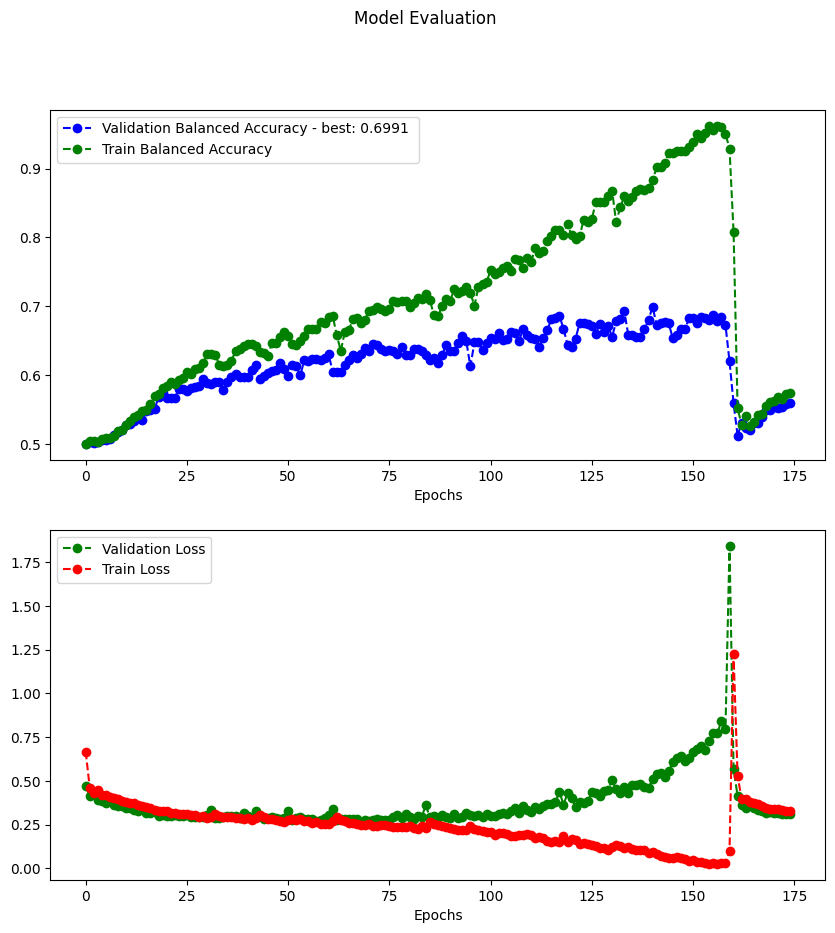

40/40 [==============================] - 0s 3ms/step
[[0.87370104 0.        ]
 [0.12629896 0.        ]]


In [ ]:
#nothing
model, model_history, X_validation, y_validation = neural_defandTrain("adam", "categorical_crossentropy",175,2048, X_train, y_train,  False, 0.2, 1, False, 0 ,False)
y_pred = model.predict(X_validation)
results = np.argmax(y_pred,1).copy()
y_true = np.argmax (y_validation, axis = 1)
matrix = confusion_matrix(y_true, results , normalize='pred')
print(matrix)


f1 scores: [0.93378896 0.03726708]


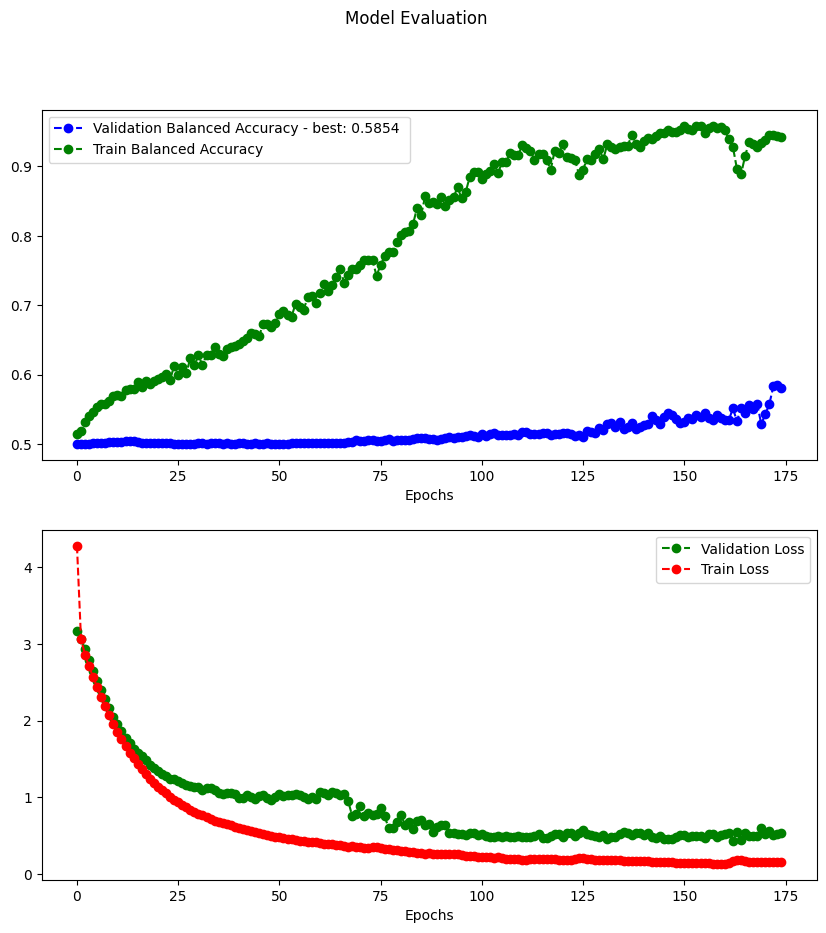

40/40 [==============================] - 0s 3ms/step
[[0.87580128 0.        ]
 [0.12419872 1.        ]]


In [ ]:

#with reguralization
model, model_history, X_validation, y_validation = neural_defandTrain("adam", "categorical_crossentropy",175,2048, X_train, y_train,  False, 0.2, 1, False, 1 ,False)
y_pred = model.predict(X_validation)
results = np.argmax(y_pred,1).copy()
y_true = np.argmax (y_validation, axis = 1)
matrix = confusion_matrix(y_true, results , normalize='pred')
print(matrix)


f1 scores: [0.93316084 0.15300545]


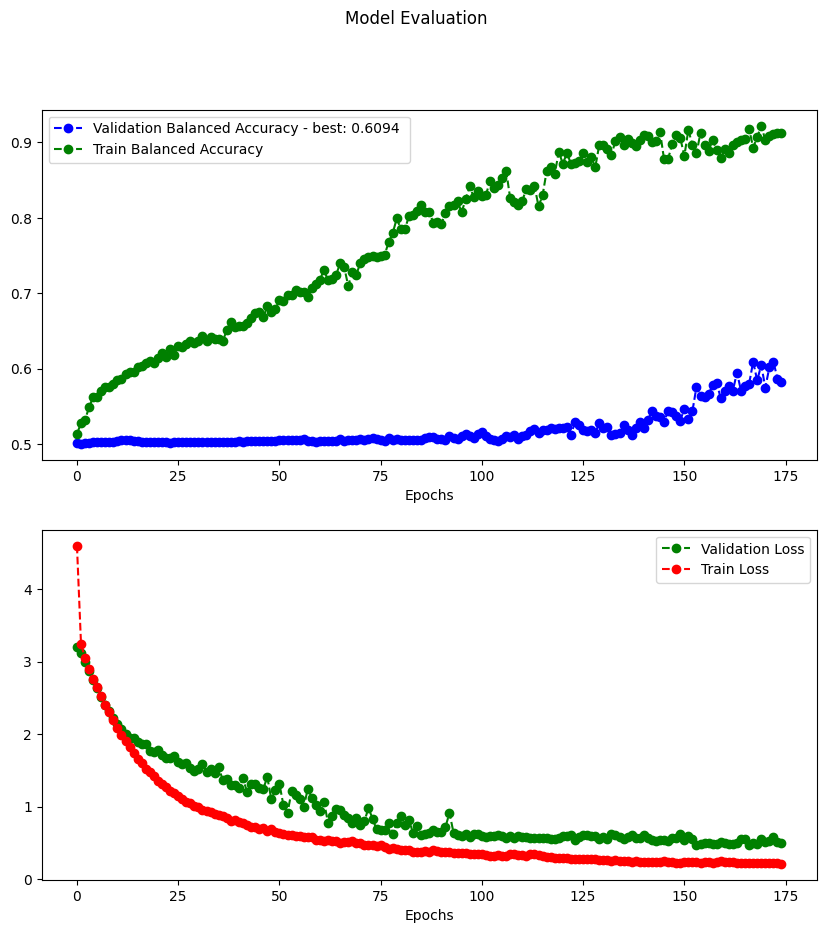

40/40 [==============================] - 0s 3ms/step
[[0.88254486 0.44      ]
 [0.11745514 0.56      ]]


In [ ]:
#class weights
model, model_history, X_validation, y_validation = neural_defandTrain("adam", "categorical_crossentropy",175,2048, X_train, y_train,  True, 0.2, 1, False, 1 ,False)
y_pred = model.predict(X_validation)
results = np.argmax(y_pred,1).copy()
y_true = np.argmax (y_validation, axis = 1)
matrix = confusion_matrix(y_true, results , normalize='pred')
print(matrix)



f1 scores: [0.9236397  0.46984127]


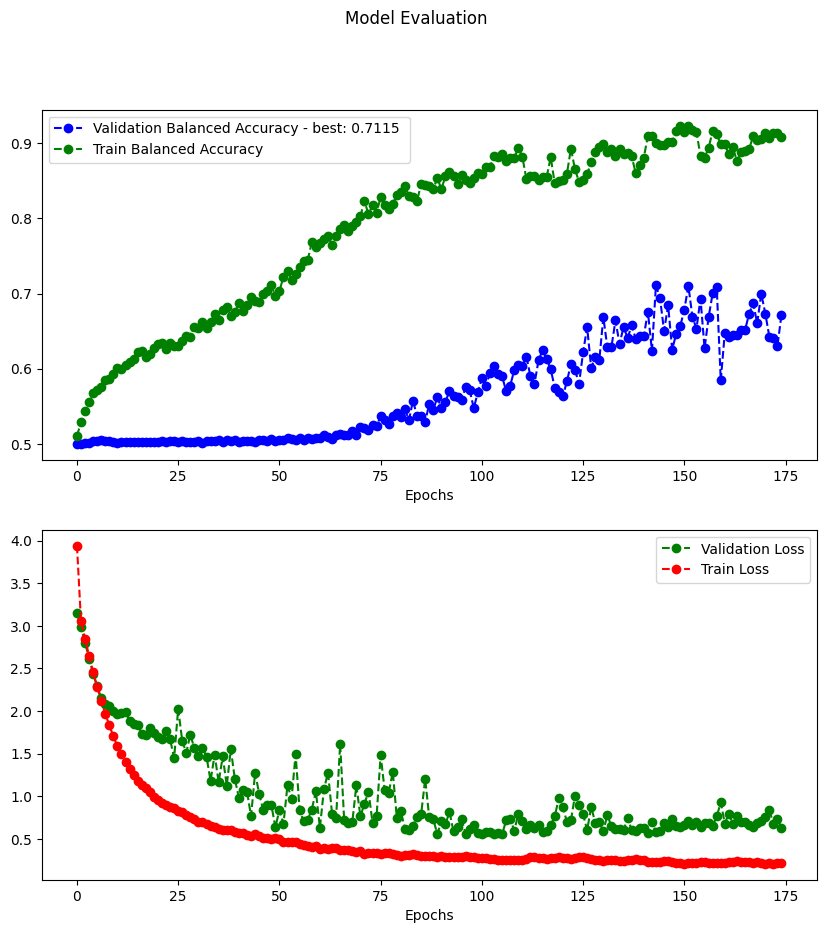

40/40 [==============================] - 0s 3ms/step
[[0.90178571 0.4351145 ]
 [0.09821429 0.5648855 ]]


In [ ]:
#batch size 1024
model, model_history, X_validation, y_validation = neural_defandTrain("adam", "categorical_crossentropy",175,1024, X_train, y_train,  True, 0.2, 1, False, 1 ,False)
y_pred = model.predict(X_validation)
results = np.argmax(y_pred,1).copy()
y_true = np.argmax (y_validation, axis = 1)
matrix = confusion_matrix(y_true, results , normalize='pred')
print(matrix)

f1 scores: [0.79766953 0.37785017]


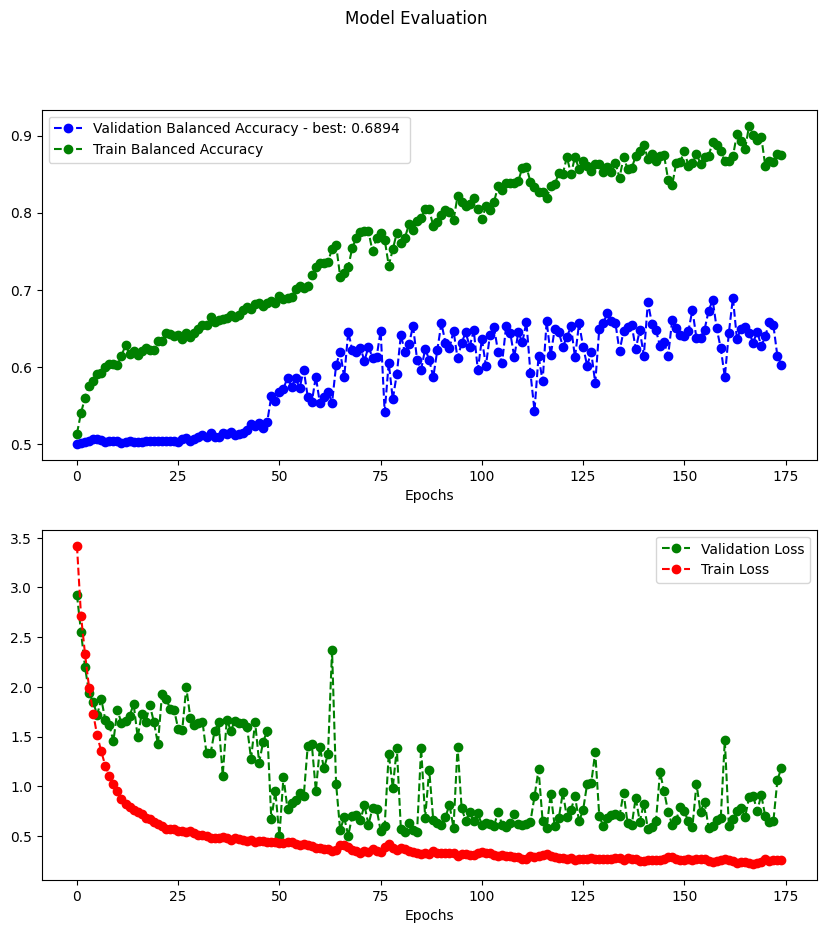

40/40 [==============================] - 1s 3ms/step
[[0.94716981 0.74561404]
 [0.05283019 0.25438596]]


In [ ]:
#batch size 512
model, model_history, X_validation, y_validation = neural_defandTrain("adam", "categorical_crossentropy",175,512, X_train, y_train,  True, 0.2, 1, False, 1 ,False)
y_pred = model.predict(X_validation)
results = np.argmax(y_pred,1).copy()
y_true = np.argmax (y_validation, axis = 1)
matrix = confusion_matrix(y_true, results , normalize='pred')
print(matrix)

f1 scores: [0.82642895 0.44369745]


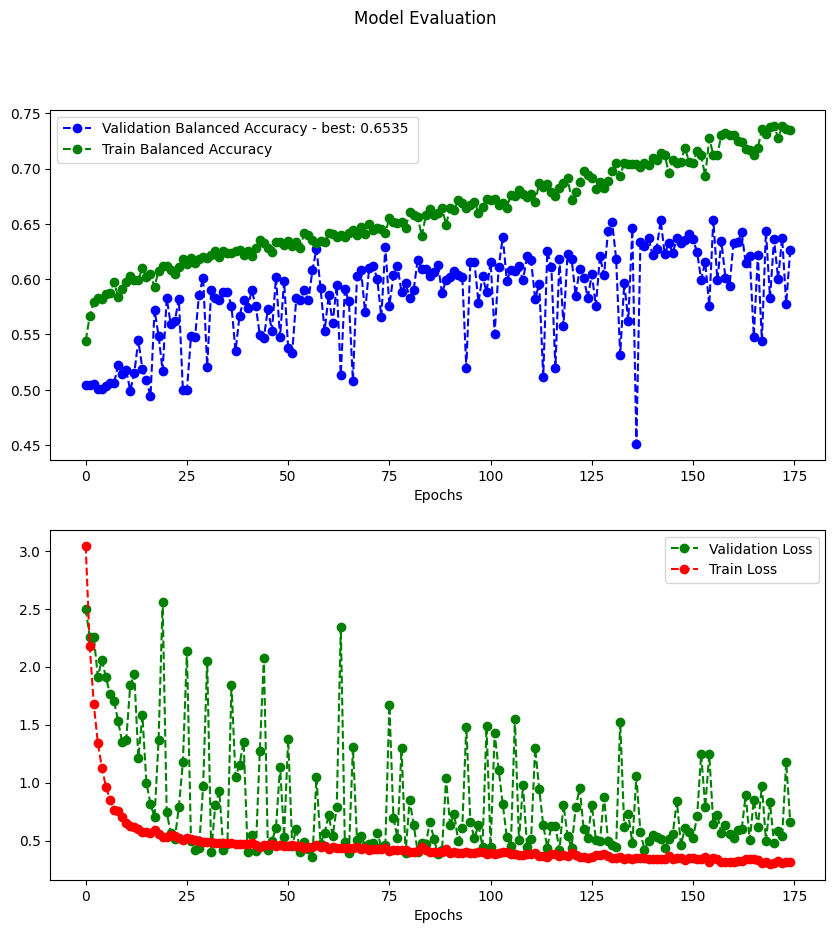

40/40 [==============================] - 0s 3ms/step
[[0.96805897 0.6979405 ]
 [0.03194103 0.3020595 ]]


In [ ]:
#batch size 128
model, model_history, X_validation, y_validation = neural_defandTrain("adam", "categorical_crossentropy",175,128, X_train, y_train,  True, 0.2, 1, False, 1 ,False)
y_pred = model.predict(X_validation)
results = np.argmax(y_pred,1).copy()
y_true = np.argmax (y_validation, axis = 1)
matrix = confusion_matrix(y_true, results , normalize='pred')
print(matrix)

f1 scores: [0.92801386 0.15306123]


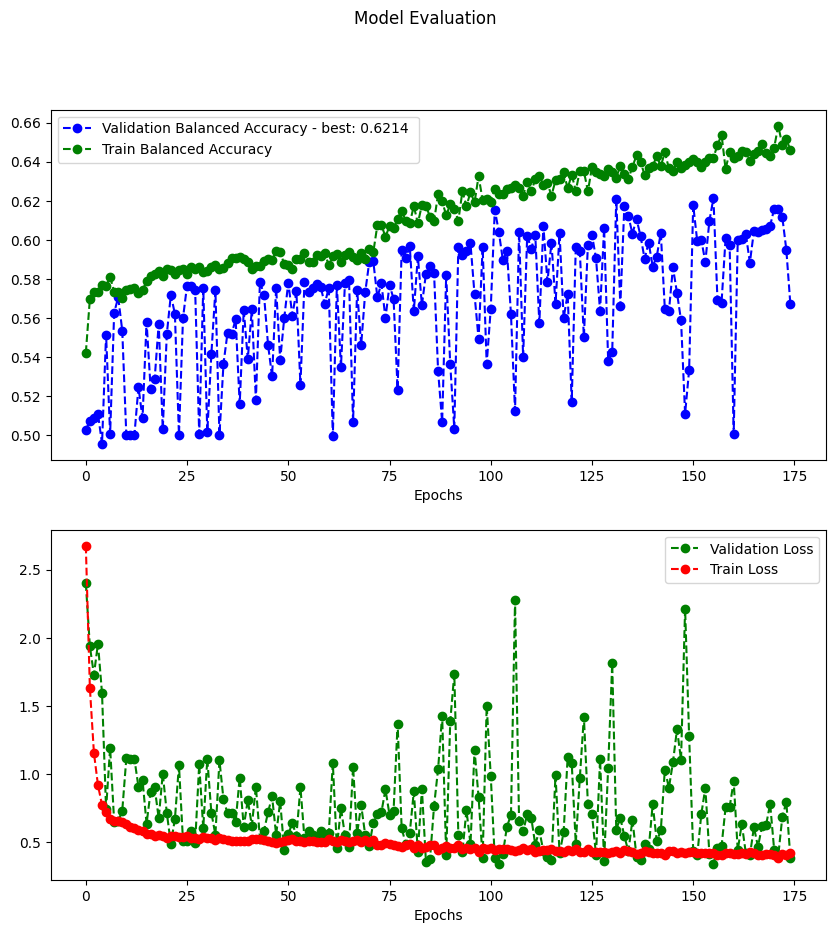

40/40 [==============================] - 0s 3ms/step
[[0.88211047 0.60526316]
 [0.11788953 0.39473684]]


In [ ]:
#batch size 64
model, model_history, X_validation, y_validation = neural_defandTrain("adam", "categorical_crossentropy",175,64, X_train, y_train,  True, 0.2, 1, False, 1 ,False)
y_pred = model.predict(X_validation)
results = np.argmax(y_pred,1).copy()
y_true = np.argmax (y_validation, axis = 1)
matrix = confusion_matrix(y_true, results , normalize='pred')
print(matrix)

f1 scores: [0.73515975 0.38133335]


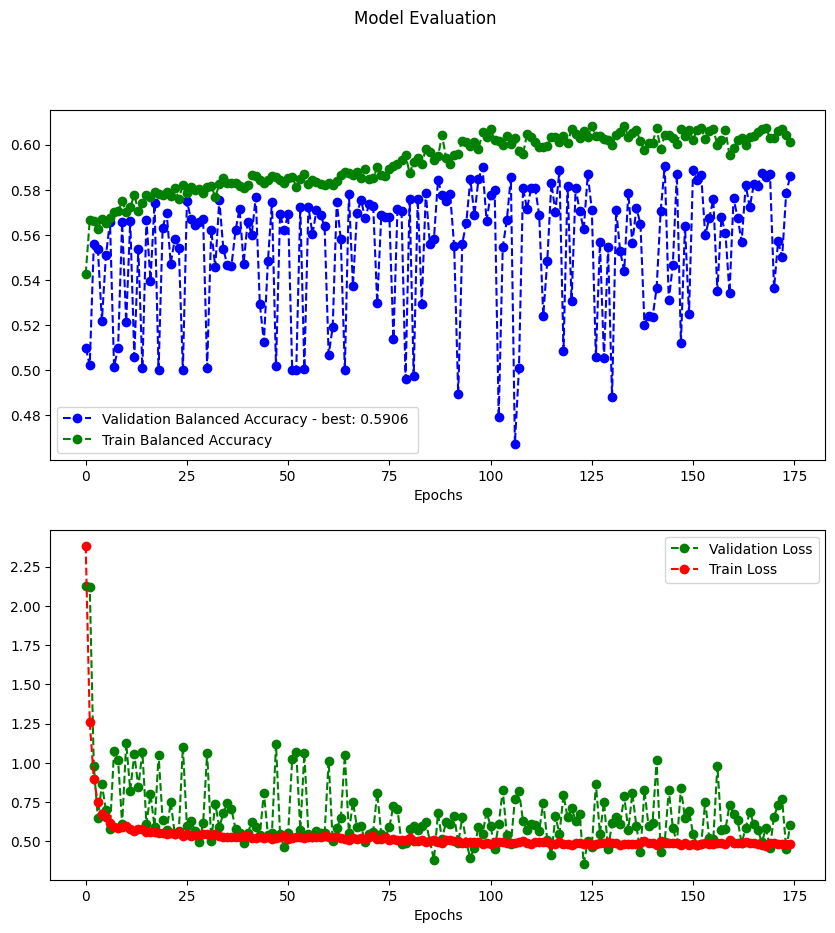

40/40 [==============================] - 0s 3ms/step
[[0.97723824 0.75844595]
 [0.02276176 0.24155405]]


In [ ]:
#batch size 32
model, model_history, X_validation, y_validation = neural_defandTrain("adam", "categorical_crossentropy",175,32, X_train, y_train,  True, 0.2, 1, False, 1 ,False)
y_pred = model.predict(X_validation)
results = np.argmax(y_pred,1).copy()
y_true = np.argmax (y_validation, axis = 1)
matrix = confusion_matrix(y_true, results , normalize='pred')
print(matrix)

f1 scores: [0.91312563 0.5208334 ]


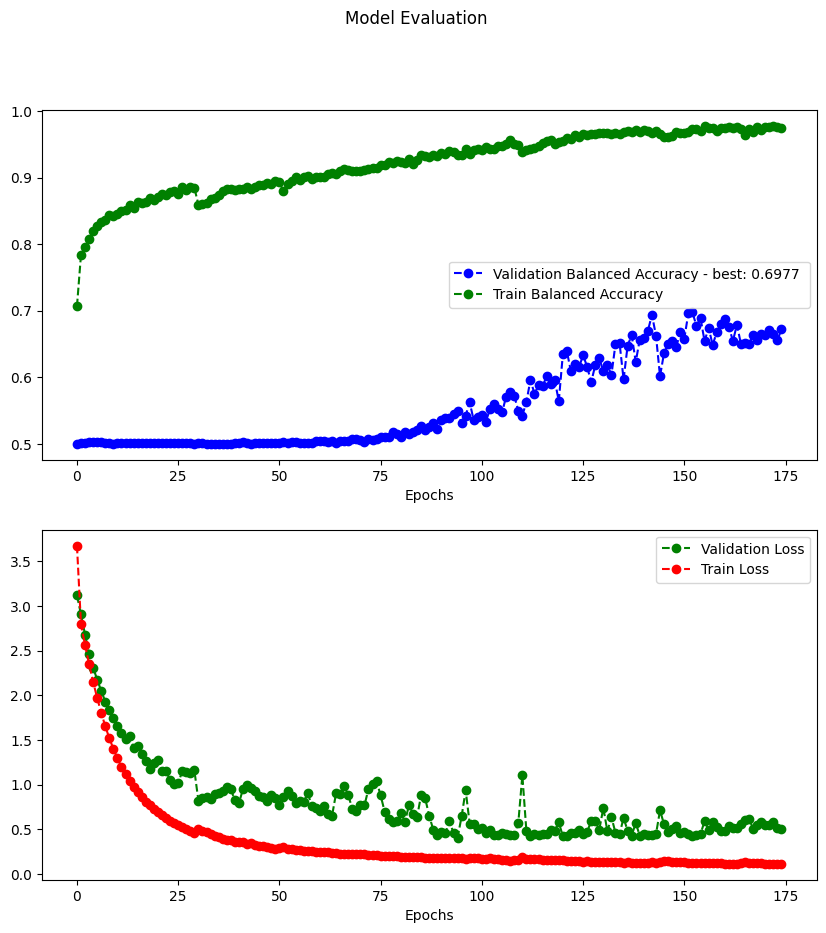

40/40 [==============================] - 0s 3ms/step
[[0.94341463 0.55752212]
 [0.05658537 0.44247788]]


In [ ]:
#oversampling 2048
model, model_history, X_validation, y_validation = neural_defandTrain("adam", "categorical_crossentropy",175,2048, X_train, y_train,  False, 0.2, 1, True, 1 ,False)
y_pred = model.predict(X_validation)
results = np.argmax(y_pred,1).copy()
y_true = np.argmax (y_validation, axis = 1)
matrix = confusion_matrix(y_true, results , normalize='pred')
print(matrix)




f1 scores: [0.9306667  0.38095236]


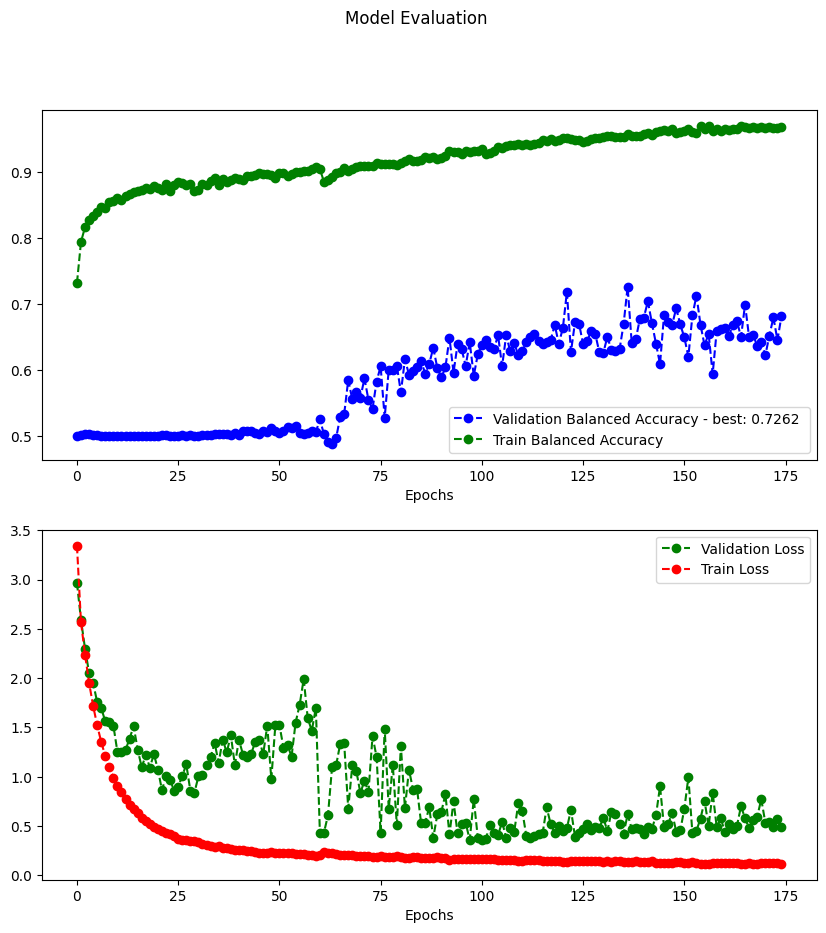

40/40 [==============================] - 0s 5ms/step
[[0.90492653 0.4893617 ]
 [0.09507347 0.5106383 ]]


In [ ]:
#oversampling 1024
model, model_history, X_validation, y_validation = neural_defandTrain("adam", "categorical_crossentropy",175,1024, X_train, y_train,  False, 0.2, 1, True, 1 ,False)
y_pred = model.predict(X_validation)
results = np.argmax(y_pred,1).copy()
y_true = np.argmax (y_validation, axis = 1)
matrix = confusion_matrix(y_true, results , normalize='pred')
print(matrix)


f1 scores: [0.88317984 0.45102504]


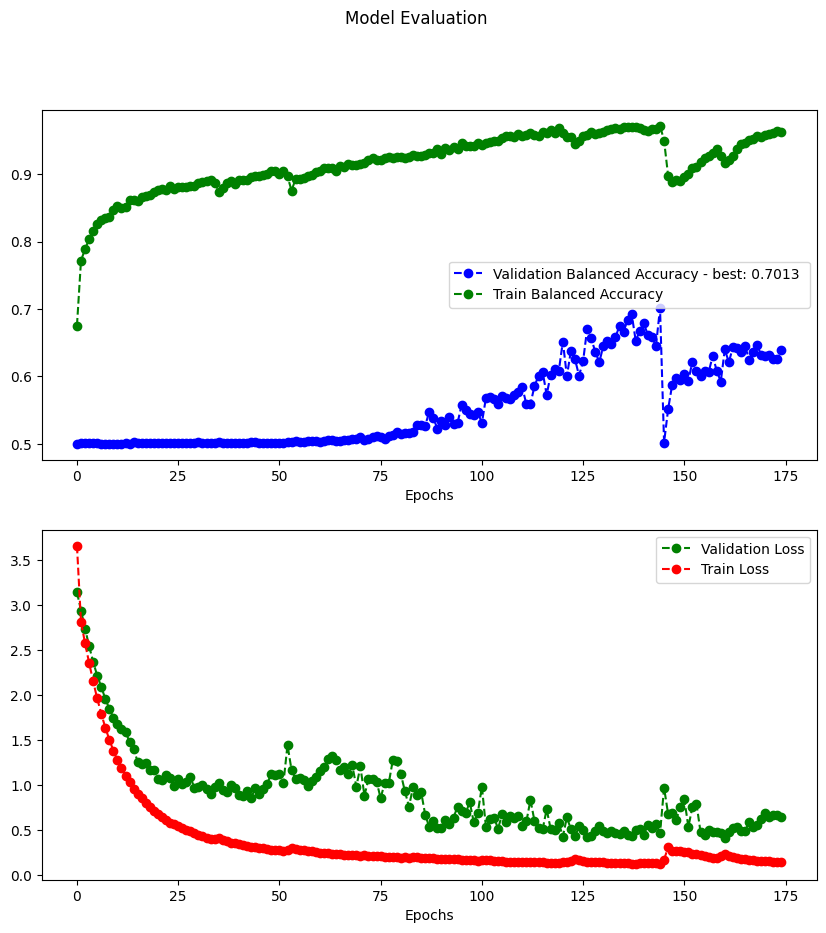

40/40 [==============================] - 0s 4ms/step
[[0.92020202 0.62068966]
 [0.07979798 0.37931034]]


In [ ]:
#shuffling oversampling
model, model_history, X_validation, y_validation = neural_defandTrain("adam", "categorical_crossentropy",175,2048, X_train, y_train,  False, 0.2, 1, True, 1 ,True)
y_pred = model.predict(X_validation)
results = np.argmax(y_pred,1).copy()
y_true = np.argmax (y_validation, axis = 1)
matrix = confusion_matrix(y_true, results , normalize='pred')
print(matrix)




f1 scores: [0.84016824 0.49333337]


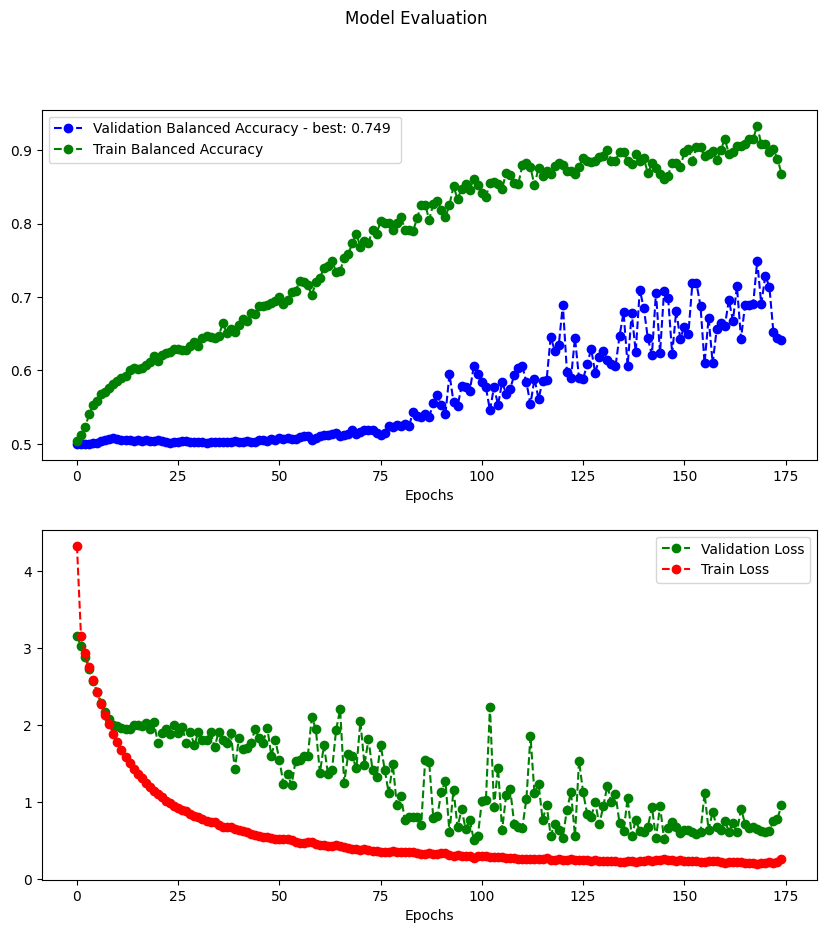

40/40 [==============================] - 0s 3ms/step
[[0.95574163 0.64337349]
 [0.04425837 0.35662651]]


In [ ]:
#class weights and shuffle
model, model_history, X_validation, y_validation = neural_defandTrain("adam", "categorical_crossentropy",175,1024, X_train, y_train,  True, 0.2, 1, False, 1 ,True)
y_pred = model.predict(X_validation)
results = np.argmax(y_pred,1).copy()
y_true = np.argmax (y_validation, axis = 1)
matrix = confusion_matrix(y_true, results , normalize='pred')
print(matrix)

f1 scores: [0.9105765 0.3411371]


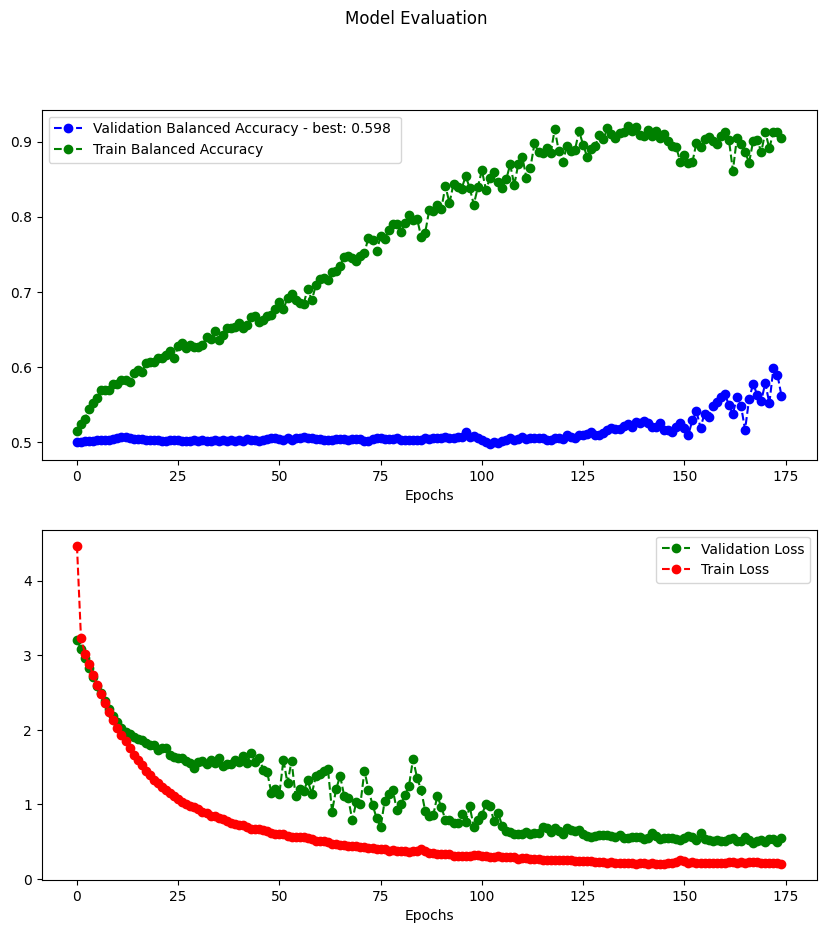

40/40 [==============================] - 0s 3ms/step
[[0.88370044 0.56034483]
 [0.11629956 0.43965517]]


In [ ]:
#class weights and shuffle
model, model_history, X_validation, y_validation = neural_defandTrain("adam", "categorical_crossentropy",175,2048, X_train, y_train,  True, 0.2, 1, False, 1 ,True)
y_pred = model.predict(X_validation)
results = np.argmax(y_pred,1).copy()
y_true = np.argmax (y_validation, axis = 1)
matrix = confusion_matrix(y_true, results , normalize='pred')
print(matrix)

f1 scores: [0.8450262 0.5      ]


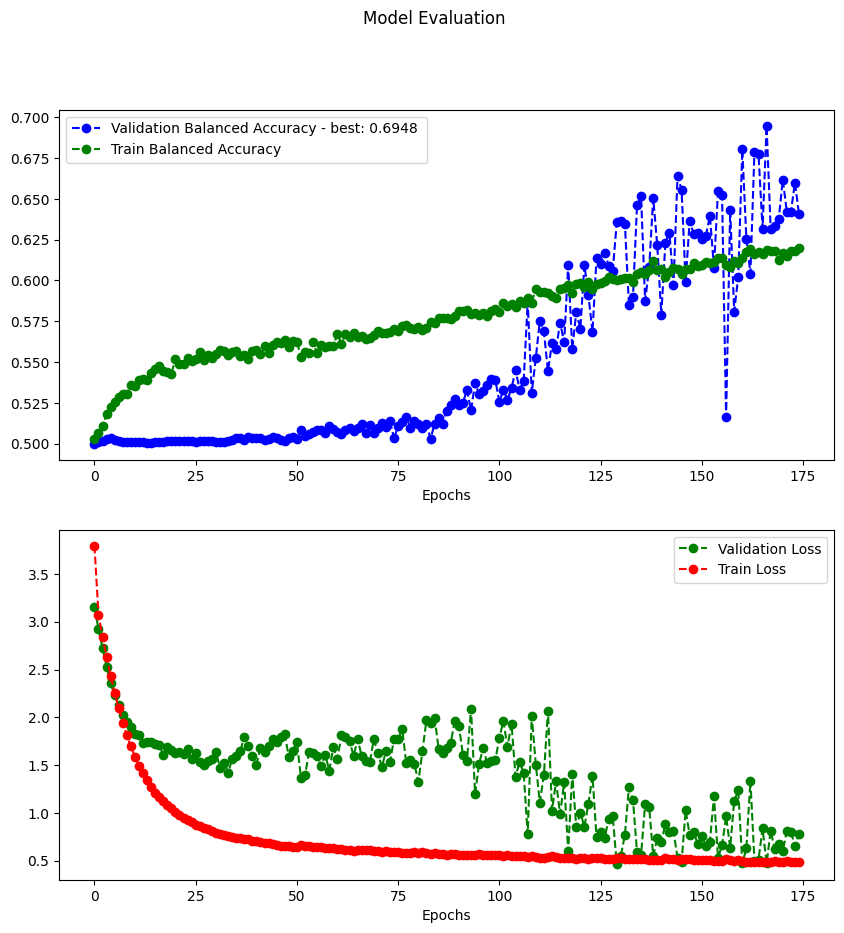

40/40 [==============================] - 0s 3ms/step
[[0.9584323  0.63814181]
 [0.0415677  0.36185819]]


In [ ]:
#data augmentation 2 class weights 2048
model, model_history, X_validation, y_validation = neural_defandTrain("adam", "categorical_crossentropy",175,2048, X_train, y_train,  True, 0.2, 2, False, 1 ,True)
y_pred = model.predict(X_validation)
results = np.argmax(y_pred,1).copy()
y_true = np.argmax (y_validation, axis = 1)
matrix = confusion_matrix(y_true, results , normalize='pred')
print(matrix)

f1 scores: [0.9222324  0.46202528]


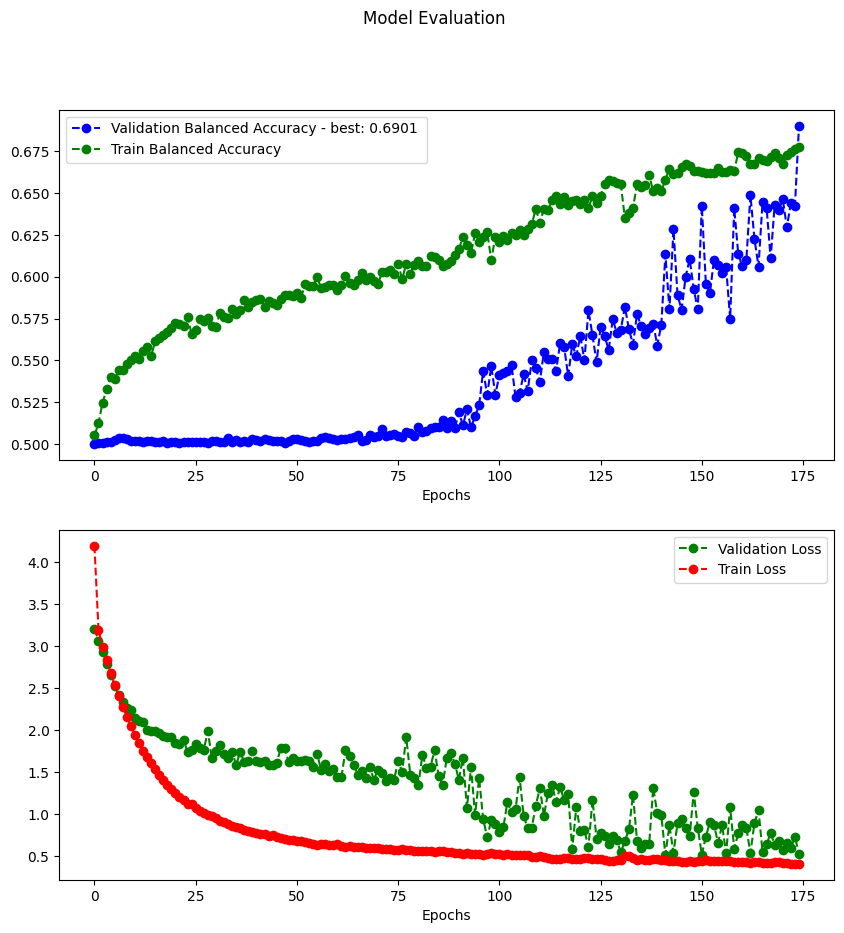

40/40 [==============================] - 0s 3ms/step
[[0.90161002 0.45112782]
 [0.09838998 0.54887218]]


In [ ]:
#data augmentation 1.5 class weights 2048
model, model_history, X_validation, y_validation = neural_defandTrain("adam", "categorical_crossentropy",175,2048, X_train, y_train,  True, 0.2, 1.5, False, 1 ,True)
y_pred = model.predict(X_validation)
results = np.argmax(y_pred,1).copy()
y_true = np.argmax (y_validation, axis = 1)
matrix = confusion_matrix(y_true, results , normalize='pred')
print(matrix)

f1 scores: [0.8455538  0.48704663]


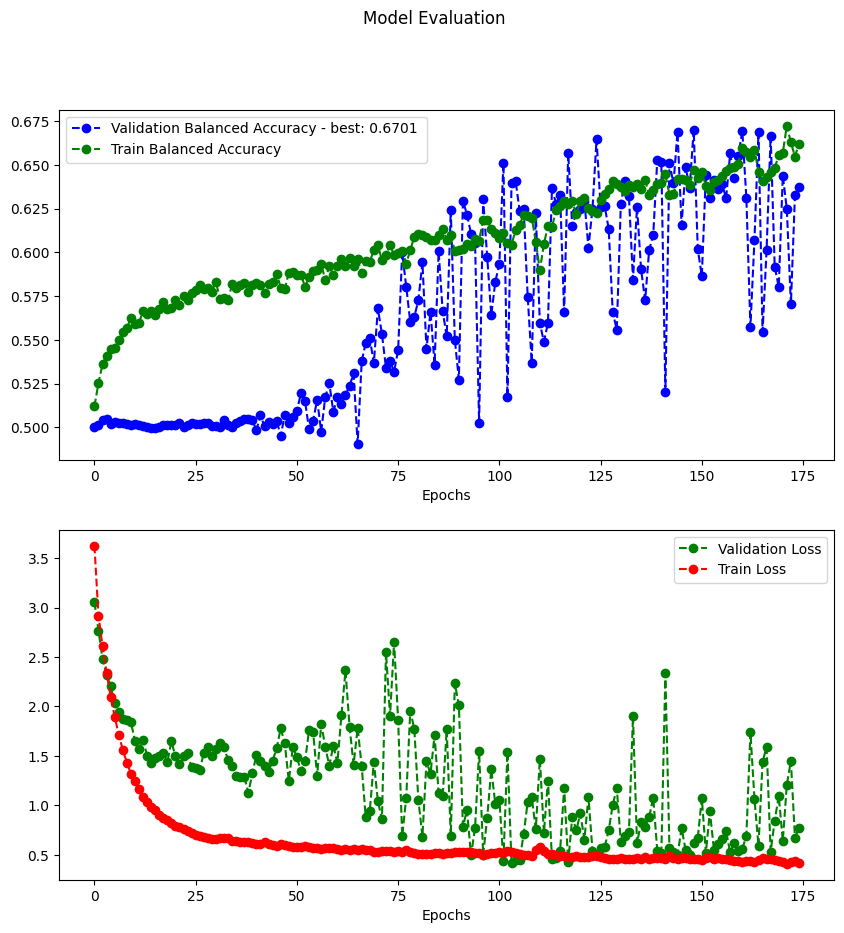

40/40 [==============================] - 0s 3ms/step
[[0.94755245 0.64122137]
 [0.05244755 0.35877863]]


In [ ]:
#data augmentation 1.5 class weights 1024
model, model_history, X_validation, y_validation = neural_defandTrain("adam", "categorical_crossentropy",175,1024, X_train, y_train,  True, 0.2, 1.5, False, 1 ,True)
y_pred = model.predict(X_validation)
results = np.argmax(y_pred,1).copy()
y_true = np.argmax (y_validation, axis = 1)
matrix = confusion_matrix(y_true, results , normalize='pred')
print(matrix)

f1 scores: [0.9114286  0.53731346]


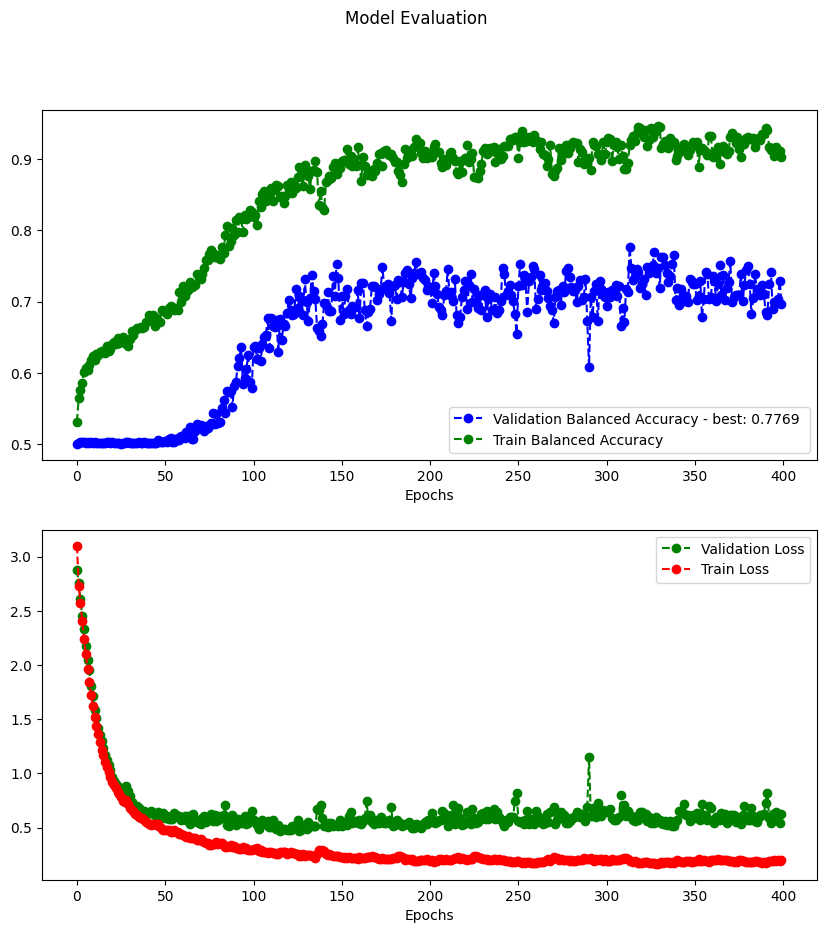

40/40 [==============================] - 0s 4ms/step
[[0.92732558 0.50684932]
 [0.07267442 0.49315068]]


In [ ]:
#new model
#class weights and shuffle 1024
model, model_history, X_validation, y_validation = neural_defandTrain("adam", "categorical_crossentropy",400,1024, X_train, y_train,  True, 0.2, 1, False, 2 ,True)
y_pred = model.predict(X_validation)
results = np.argmax(y_pred,1).copy()
y_true = np.argmax (y_validation, axis = 1)
matrix = confusion_matrix(y_true, results , normalize='pred')
print(matrix)

f1 scores: [0.9284726  0.53731346]


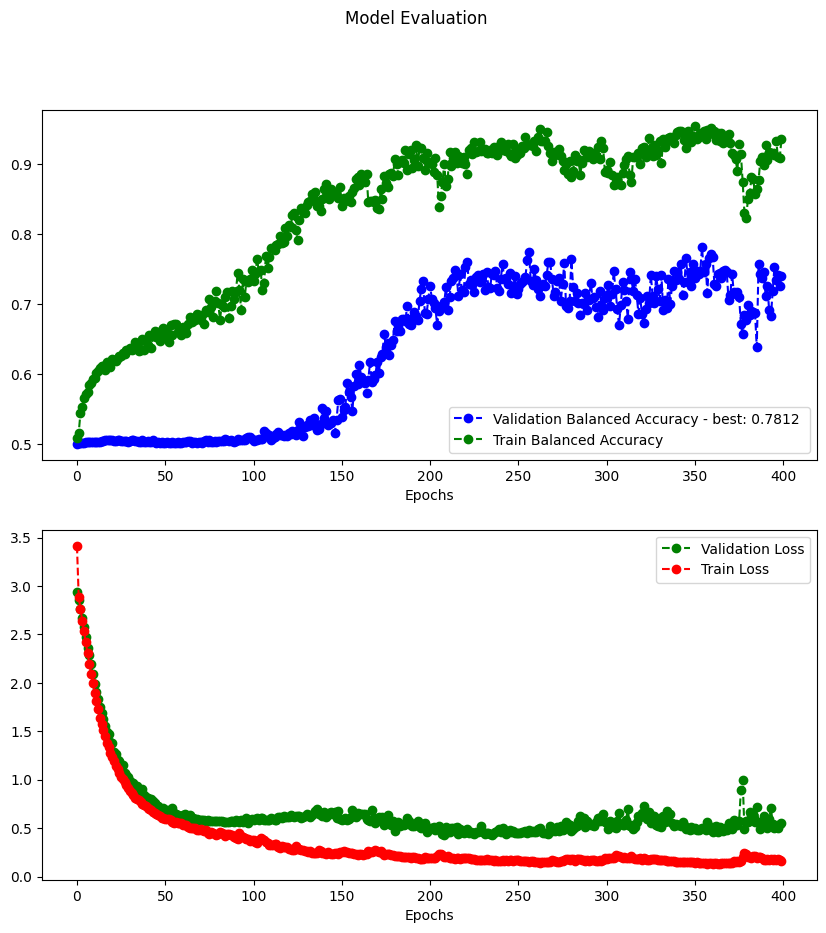

40/40 [==============================] - 0s 3ms/step
[[0.91537762 0.40789474]
 [0.08462238 0.59210526]]


In [ ]:
#new model
#class weights and shuffle 2048
model, model_history, X_validation, y_validation = neural_defandTrain("adam", "categorical_crossentropy",400,2048, X_train, y_train,  True, 0.2, 1, False, 2 ,True)
y_pred = model.predict(X_validation)
results = np.argmax(y_pred,1).copy()
y_true = np.argmax (y_validation, axis = 1)
matrix = confusion_matrix(y_true, results , normalize='pred')
print(matrix)

f1 scores: [0.92169815 0.56544507]


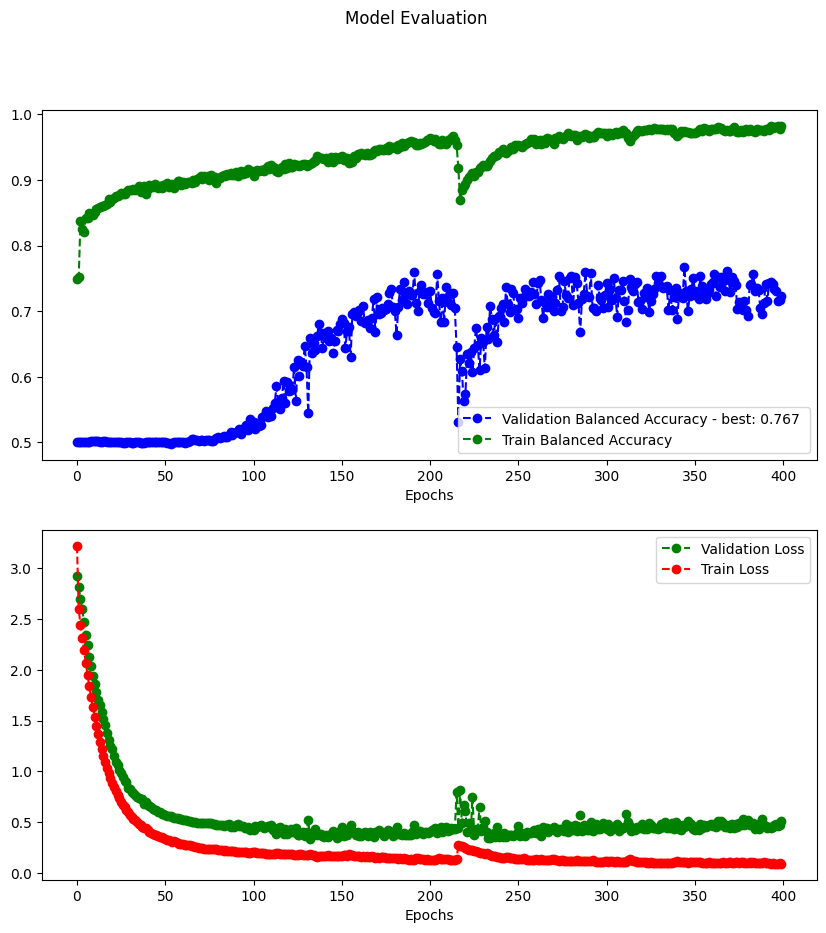

40/40 [==============================] - 0s 4ms/step
[[0.92694497 0.45177665]
 [0.07305503 0.54822335]]


In [ ]:
#delivery
#oversampling and shuffle 2048
model, model_history, X_validation, y_validation = neural_defandTrain("adam", "categorical_crossentropy",400,2048, X_train, y_train,  False, 0.2, 1, True, 2 ,True)
y_pred = model.predict(X_validation)
results = np.argmax(y_pred,1).copy()
y_true = np.argmax (y_validation, axis = 1)
matrix = confusion_matrix(y_true, results , normalize='pred')
print(matrix)

f1 scores: [0.9387211  0.44799998]


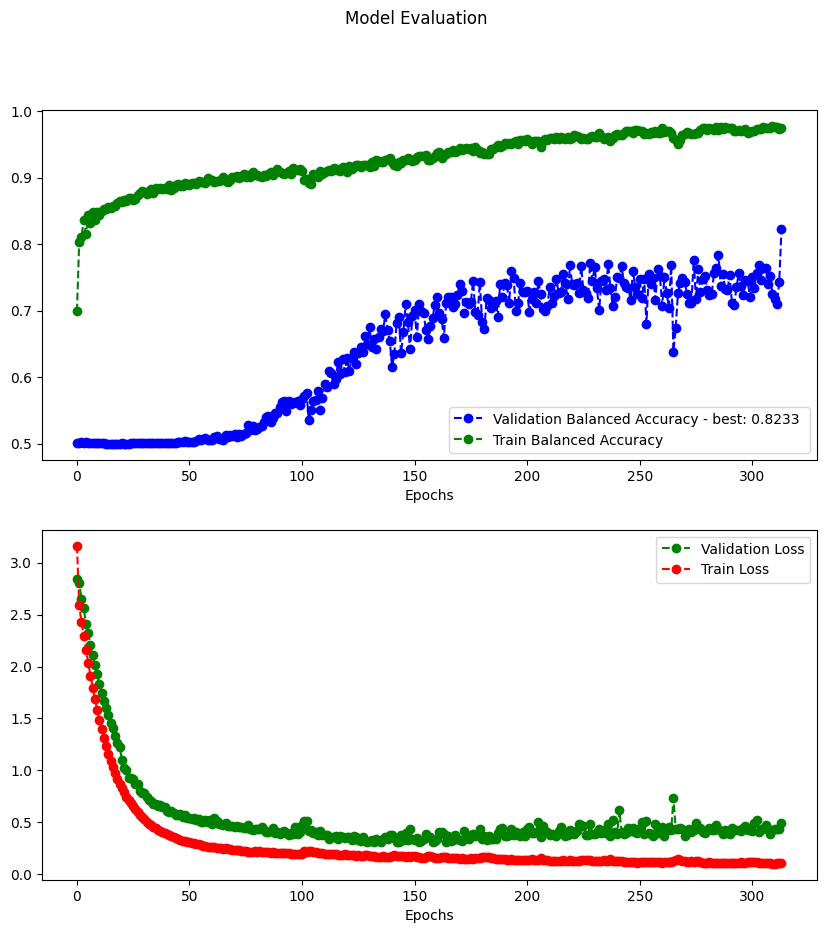

40/40 [==============================] - 0s 3ms/step
[[0.89273649 0.1641791 ]
 [0.10726351 0.8358209 ]]


In [ ]:
#delivery
#oversampling and shuffle 2048
model, model_history, X_validation, y_validation = neural_defandTrain("adam", "categorical_crossentropy",400,2048, X_train, y_train,  False, 0.2, 1.5, True, 2 ,True)
y_pred = model.predict(X_validation)
results = np.argmax(y_pred,1).copy()
y_true = np.argmax (y_validation, axis = 1)
matrix = confusion_matrix(y_true, results , normalize='pred')
print(matrix)

f1 scores: [0.9220056 0.5172414]


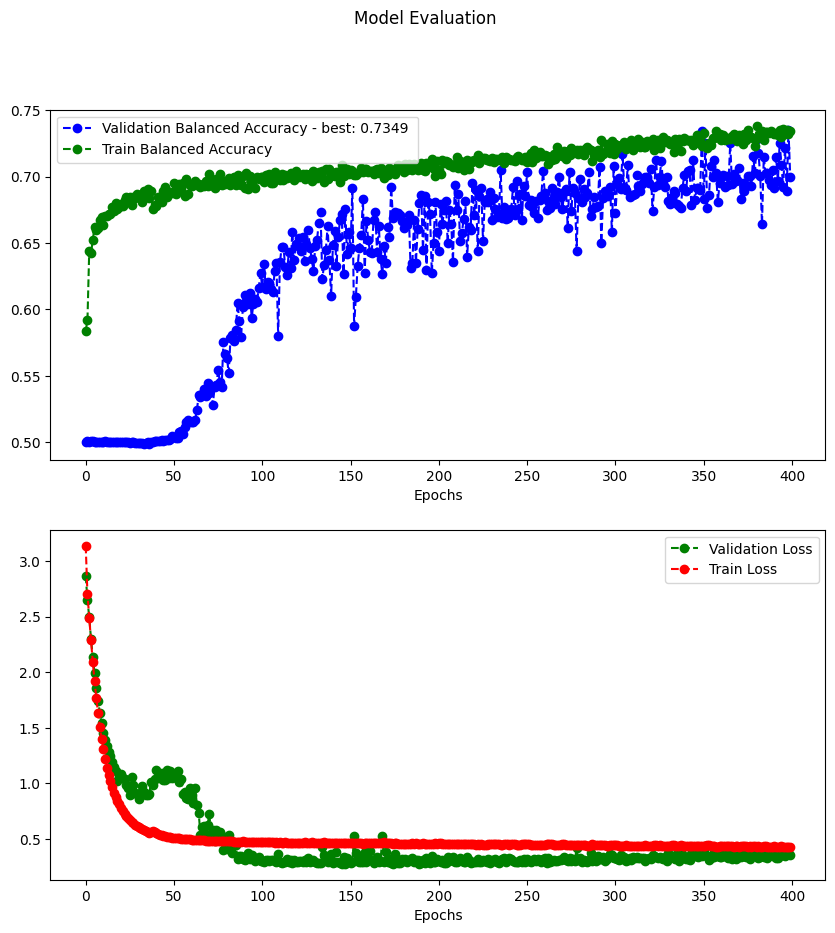

40/40 [==============================] - 1s 6ms/step
[[0.92115028 0.47976879]
 [0.07884972 0.52023121]]


In [16]:
#delivery same as above
#oversampling and shuffle 2048
model, model_history, X_validation, y_validation = neural_defandTrain("adam", "categorical_crossentropy",400,2048, X_train, y_train,  False, 0.2, 1.5, True, 2 ,True)
y_pred = model.predict(X_validation)
results = np.argmax(y_pred,1).copy()
y_true = np.argmax (y_validation, axis = 1)
matrix = confusion_matrix(y_true, results , normalize='pred')
print(matrix)

f1 scores: [0.92729765 0.49523807]


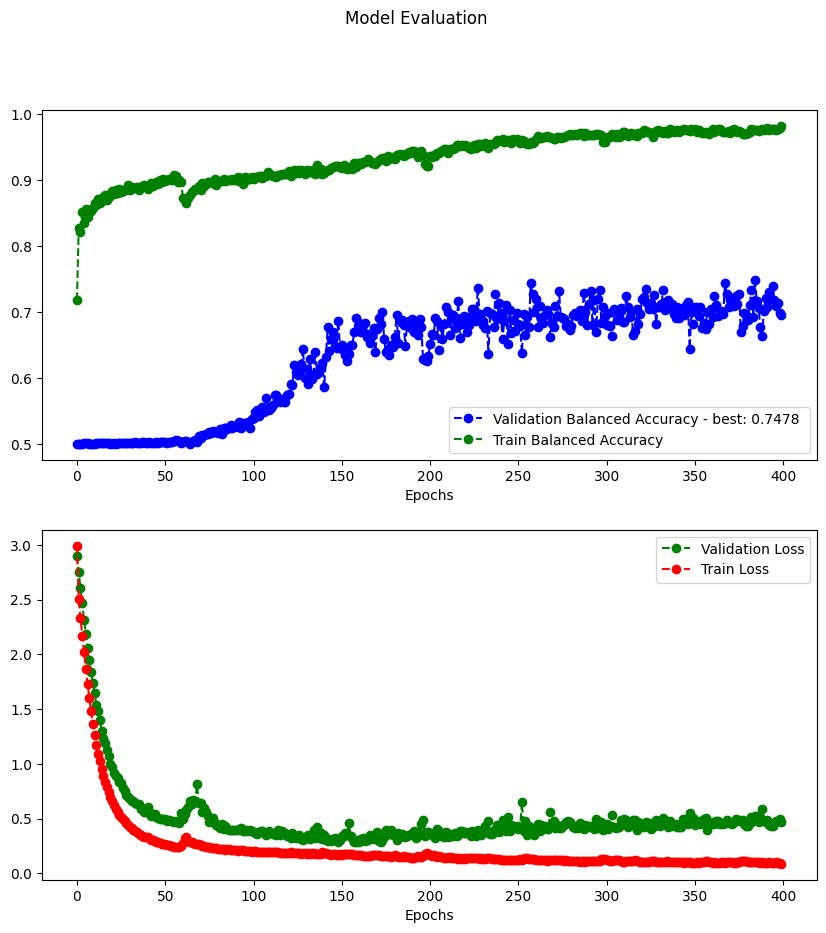

40/40 [==============================] - 1s 7ms/step
[[0.92098093 0.48      ]
 [0.07901907 0.52      ]]


In [ ]:
#delivery
#oversampling and shuffle 2048
model, model_history, X_validation, y_validation = neural_defandTrain("adam", "categorical_crossentropy",400,2048, X_train, y_train,  False, 0.2, 1, True, 2 ,True)
y_pred = model.predict(X_validation)
results = np.argmax(y_pred,1).copy()
y_true = np.argmax (y_validation, axis = 1)
matrix = confusion_matrix(y_true, results , normalize='pred')
print(matrix)

f1 scores: [0.9244486 0.5660378]


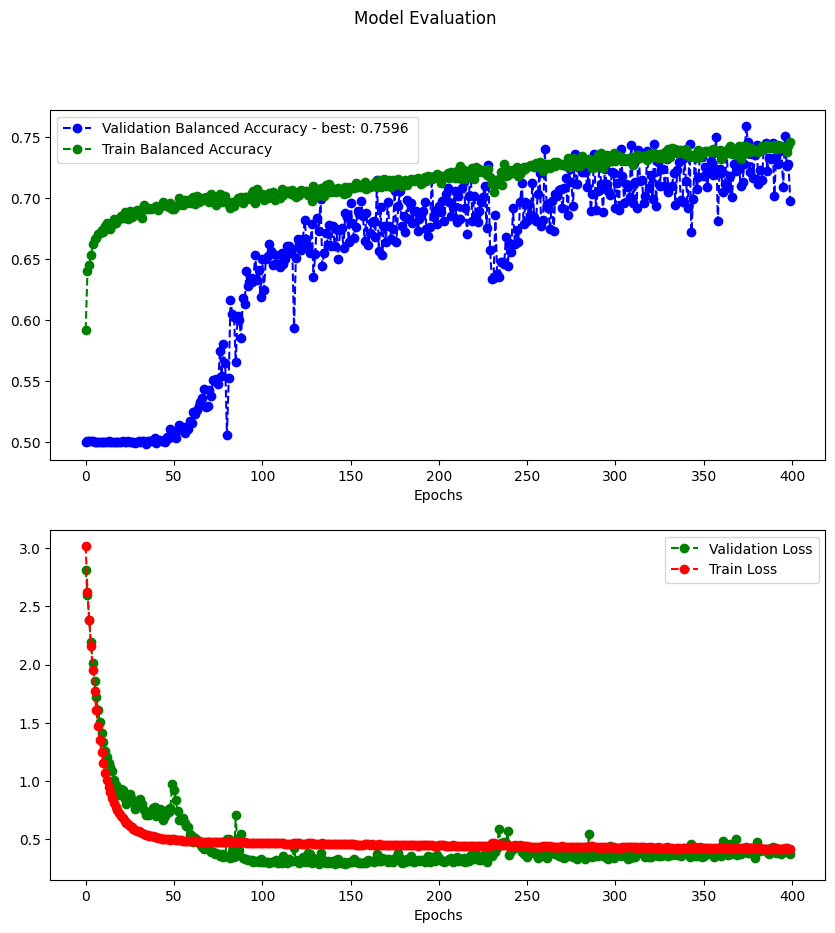

40/40 [==============================] - 0s 2ms/step
[[0.92488263 0.43548387]
 [0.07511737 0.56451613]]


In [ ]:
#delivery
#oversampling and shuffle 2048
model, model_history, X_validation, y_validation = neural_defandTrain("adam", "categorical_crossentropy",400,2048, X_train, y_train,  False, 0.2, 1.5, True, 2 ,True)
y_pred = model.predict(X_validation)
results = np.argmax(y_pred,1).copy()
y_true = np.argmax (y_validation, axis = 1)
matrix = confusion_matrix(y_true, results , normalize='pred')
print(matrix)